# Sentinel 1 and 2

The aim of this notebook is to guide you how to get Sentinel data using Sentinelhub and eo-learn. Price for subscription is described there https://www.sentinel-hub.com/pricing/.

The workflow for agriculture purposes is as follows :

1) Read shapefile that represent you field (boundaries or microplots)

2) Extract Sentinel-2 data and compute averaged NDVI time series to get a summary of the season vegetation dynamic.

3) Extract Sentinel-1 data and apply multitemporal speckle filtering

## Set your working environment

### Import the packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
from scipy.signal import savgol_filter

import os
import numpy as np
import matplotlib.pyplot as plt
from eolearn.core import FeatureType

from eocrops.input import utils_sh as utils_sh
from eocrops.input import sentinel1 as sentinel1
from eocrops.input import sentinel2 as sentinel2
from eocrops.tasks import cmd_otb as cmd_otb
from eocrops.tasks import preprocessing as preprocessing


### Read your vector file

In [2]:
dir_path = os.path.dirname(os.getcwd())
print(dir_path)
#read microplot data
shapefile_input = gpd.read_file(os.path.join(dir_path, './examples/layers/POLYGON.shp'))

/home/johann/Documents/git-repo/eo-crops


/home/johann/anaconda3/envs/eo-crops/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
api =''
client_id =''
client_secret =''
config = utils_sh.config_sentinelhub_cred(api, client_id, client_secret)
#Provide here your planet API key 
config.planet_key = ''

/home/johann/anaconda3/envs/eo-crops/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
time_period = ('2020-02-15', '2020-08-15')
kwargs = dict(polygon=shapefile_input,
              time_stamp=time_period,
              config=config)

## Extract S2 data

In [19]:
warnings.filterwarnings("ignore")
patch = sentinel2.workflow_instructions_S2L2A(**kwargs,
                                              path_out = None, #you can specify here a path to save the EOPatch object
                                              coverage_predicate=0.5,
                                              interpolation={'interpolate' : True,
                                                             'period_length' : 8})  # you can add period_length in the dictionary to resample


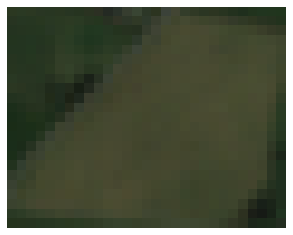

In [20]:
#RGB
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(patch.data['BANDS-S2-L2A'][4][..., [2, 1, 0]]*2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);
plt.show()

In [21]:
masking = preprocessing.MaskPixels(["NDVI", "LAI"])
patch = masking.execute(patch, erosion = 1)

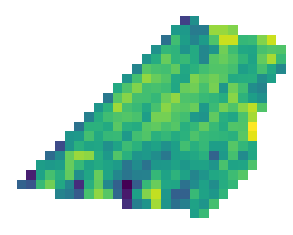

In [23]:
#NDVI
plt.figure(figsize=(5, 5))
plt.imshow(patch.data['NDVI'][15,].squeeze());
plt.axis(False);
plt.show()

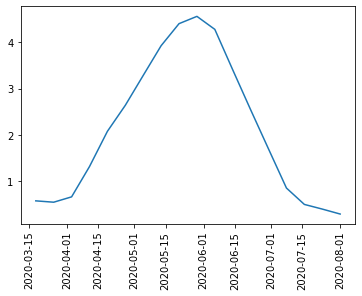

In [24]:
#LAI Time Series from masked field
variable = 'LAI'

stats_df = preprocessing.get_time_series_profile(feature_array = patch.data[variable],
                                                 crop_mask = patch.mask_timeless['MASK'],
                                                 function=np.nanmedian)

plt.plot(patch.timestamp, stats_df)
plt.xticks(rotation=90)
plt.show()

In [25]:
#Peak of the season is at 31/05 
time_argmax = np.nanargmax(stats_df)
patch.timestamp[time_argmax]

datetime.datetime(2020, 5, 29, 0, 0)

In [27]:
#If you would like to save the data in .tif format (e.g. NDVI on the first date)
from eolearn.io.local_io import ExportToTiffTask
index_time = 0
date = str(patch.timestamp[index_time]).split(' ')[0]

export = ExportToTiffTask(feature='NDVI',
                          folder=os.path.join('your_path_'+ date),
                          band_indices=[0],
                          date_indices=[index_time])
patch = export.execute(patch)

## Extract Sentinel-1 data 

In [28]:
s1_eopatch = sentinel1.workflow_instructions_S1IW(**kwargs,
                                                  speckle_lee_window = 3,
                                                  orbit_direction = 'ASC',
                                                  backCoeff = 'SIGMA0_ELLIPSOID' ) 

In [29]:
#Compute Radar Vegetation Index
VV = s1_eopatch.data['BANDS-S1-IW'][...,0]
VH =  s1_eopatch.data['BANDS-S1-IW'][...,1]
RVI = (4*VH)/(VH+VV)
#Add the feature to the EOPatch
s1_eopatch.add_feature(FeatureType.DATA, "RVI", RVI[..., np.newaxis])
masking = preprocessing.MaskPixels([ "RVI"])
s1_eopatch = masking.execute(s1_eopatch)

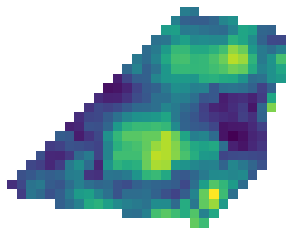

In [31]:
#Display RVI from SIGMA0 without any speckle filtering
s1_eopatch = masking.execute(s1_eopatch)
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data['RVI'][15,].squeeze());
plt.axis(False);
plt.show()

You can easily download and install OTB https://www.orfeo-toolbox.org/CookBook/Installation.html#linux, which allows you to apply Quegan multitemporal speckle filtering

In [33]:
#Can take around 30 seconds
mutlitemp = cmd_otb.MultitempSpeckleFiltering(otb_path = '/home/johann/Documents/OTB/OTB-8.0.1-Linux64/bin',
                                             window = 3)
s1_eopatch = mutlitemp.execute(s1_eopatch)

In [35]:
#Compare backscatter values after multitemporal smoothing
VH = s1_eopatch.data['VH_filtered']
VV = s1_eopatch.data['VV_filtered']
RVI_smoothed = (4*VH)/(VH+VV)
#Add the value smoothed to the EOPatch
s1_eopatch.add_feature(FeatureType.DATA, "RVI_smoothed", RVI_smoothed)
masking = preprocessing.MaskPixels(["RVI_smoothed"])
s1_eopatch = masking.execute(s1_eopatch)

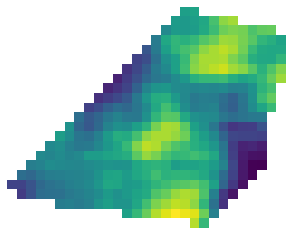

In [37]:
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data['RVI_smoothed'][15,].squeeze().squeeze());
plt.axis(False);
plt.show()

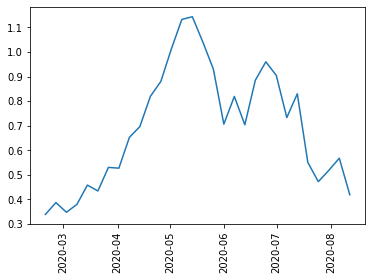

In [41]:
#LAI Time Series from masked field
variable = 'RVI_smoothed'

stats_df = preprocessing.get_time_series_profile(feature_array = s1_eopatch.data[variable],
                                                 crop_mask = s1_eopatch.mask_timeless['MASK'],
                                                 function=np.nanmedian)

plt.plot(s1_eopatch.timestamp, stats_df)
plt.xticks(rotation=90)
plt.show()